In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from stn import spatial_transformer_network as transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
os.environ['CUDA_VISIBLE_DEVICES']='3'
%matplotlib inline

#https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

/home/lhw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lhw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_file = "./dataset/train.csv"
test_file = "./dataset/test.csv"
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_train, x_val, y_train, y_val = train_test_split(raw_data[:, 1:], raw_data[:, 0], test_size=0.1)

Text(0.5,1,'28*28 data')

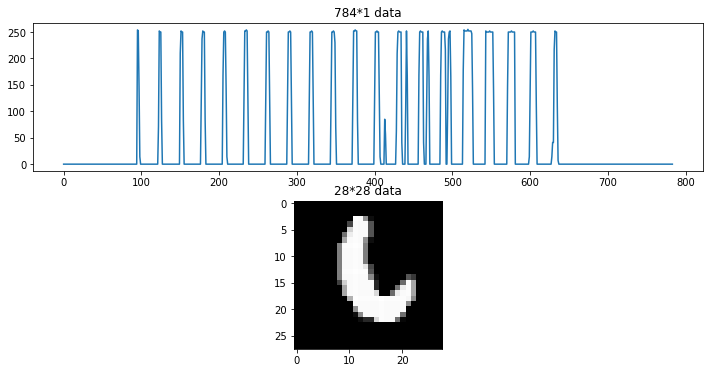

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(x_train[0])
ax[0].set_title('784*1 data')
ax[1].imshow(x_train[0].reshape(28, 28), cmap='gray')
ax[1].set_title('28*28 data')

In [4]:
def convertOneHot(y, C):
    return np.eye(C)[y.reshape(-1)]

In [5]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_train = x_train.astype("float32")/255
x_val = x_val.astype("float32")/255
y_train = convertOneHot(y_train, 10)
y_val = convertOneHot(y_val, 10)

In [6]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [13]:
### 定义STN网络 ###
#两层定位网络
def ctn_conv(x, is_training):
    # Identity transformation
    out_size = (28, 28)
    initial = np.array([[1., 0, 0], [0, 1., 0]])
    initial = initial.astype('float32')
    initial = initial.flatten()
    b_fc_loc2 = tf.Variable(initial_value=initial, name='b_fc_loc2')
    
    flatten = tf.reshape(x, [-1, 28*28*1])    
    # Frist layer
    h_fc_loc1 = tf.nn.relu(tf.layers.dense(flatten, 20))
    if is_training == True:
        h_fc_loc1 = tf.layers.dropout(relu5, 0.25)
    # Second layer
    h_fc_loc2 = tf.nn.relu(tf.layers.dense(h_fc_loc1, 6, use_bias=False) + b_fc_loc2)
    #h_fc_loc2 = tf.nn.tanh(tf.matmul(h_fc_loc1_drop, W_fc_loc2) + b_fc_loc2)
    h_trans = transformer(x, h_fc_loc2, out_size)
    return h_trans
def ctn_conv2(x, is_training):
    out_size = (32, 32)
    #定位特征提取网络
    with tf.variable_scope('location'):
        conv1 = tf.layers.conv2d(x, 8, 3, strides=1, padding='SAME')
        norm1 = tf.layers.batch_normalization(conv1, center=True, scale=True, training=is_training)
        relu1 = tf.nn.relu(norm1)
        pool1 = tf.layers.max_pooling2d(relu1, pool_size=[2, 2], strides=2, padding='SAME')
        
        conv2 = tf.layers.conv2d(pool1, 10, 3, strides=1, padding='SAME')
        norm2 = tf.layers.batch_normalization(conv2, center=True, scale=True, training=is_training)
        rule2 = tf.nn.relu(norm2)
        pool1 = tf.layers.max_pooling2d(rule2, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('regression'):
        flatten = tf.reshape(pool1, [-1, 8*8*10])
        fc1 = tf.layers.dense(flatten, 32)
        relu3 = tf.nn.relu(fc1)
        if is_training == True:
            relu3 = tf.layers.dropout(relu3, 0.5)
        fc2 = tf.layers.dense(relu3, 6)
    h_trans = transformer(x, fc2, out_size)
    return h_trans

In [14]:
def model(x, classnum, is_training):
    ### 加入STN层  ###
    with tf.variable_scope('STN'):
        stn = ctn_conv2(x, is_training)
    with tf.variable_scope('layer1'):
        layer1 = tf.layers.conv2d(x, 16, 3, strides=1, padding='VALID')
        norm1 = tf.layers.batch_normalization(layer1, center=True, scale=True, training=is_training)
        relu1 = tf.nn.relu(norm1)
    with tf.variable_scope('layer2'):
        layer2 = tf.layers.conv2d(norm1, 16, 3 , strides=1, padding='VALID')
        norm2 = tf.layers.batch_normalization(layer2, center=True, scale=True, training=is_training)
        pool2 = tf.layers.max_pooling2d(norm2, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer3'):
        layer3 = tf.layers.conv2d(pool2, 32, 3, strides=1, padding='VALID')
        norm3 = tf.layers.batch_normalization(layer3, center=True, scale=True, training=is_training)
        relu3 = tf.nn.relu(norm3)
    with tf.variable_scope('layer4'):
        layer4 = tf.layers.conv2d(norm3, 32, 3, strides=1, padding='VALID')
        norm4 = tf.layers.batch_normalization(layer4, center=True, scale=True, training=is_training)
        relu4 = tf.nn.relu(norm4)
        pool4 = tf.layers.max_pooling2d(norm4, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer5'):
        flatten = tf.reshape(pool4, [-1, 4*4*32])
        layer5 = tf.layers.dense(flatten, 512)
        relu5 = tf.nn.relu(layer5)
        if is_training == True:
            relu5 = tf.layers.dropout(relu5, 0.25)
    with tf.variable_scope('layer6'):
        layer6 = tf.layers.dense(relu5, 1024)
        relu6 = tf.nn.relu(layer6)
        if is_training == True:
            relu6 = tf.layers.dropout(relu6, 0.5)
        logits = tf.layers.dense(relu6, classnum)
    return logits

In [15]:
EARLY_STOP_PATIENCE = 10
tf.reset_default_graph()
x_data = tf.placeholder(tf.float32, [None, 28, 28, 1])
y_data = tf.placeholder(tf.float32, [None, None])
is_training = tf.placeholder(tf.bool)
model_save_path = "./model/model.ckpt"
out = model(x_data, 10, is_training)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=y_data))
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):#批归一化层
    train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, 1), tf.argmax(y_data, 1)), tf.float32))
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    best_validation_loss = 1000000.0
    current_epoch = 0
    
    epoch = 50
    batch_size = 100
    num_batch = len(x_train) // batch_size
    for n in range(epoch):
        for i in range(num_batch):
            x_batch = x_train[i*batch_size : (i+1)*batch_size]
            y_batch = y_train[i*batch_size : (i+1)*batch_size]
            _, loss_step = sess.run([train_step, loss], \
                              feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
        if (n % 5 == 0):
            if loss_step < best_validation_loss:
                best_validation_loss = loss_step
                current_epoch = n
                print(n, loss_step)
                saver.save(sess, model_save_path)
                acc = accuracy.eval({x_data:x_val, y_data:y_val, is_training:False})
                print("val: accuracy is ", acc)
            elif (n - current_epoch) >= EARLY_STOP_PATIENCE:
                print('early stoping')
                break  
    print("Finsihed")

0 0.055636965
val: accuracy is  0.6185714
5 0.011973961
val: accuracy is  0.98690474
10 0.007153554
val: accuracy is  0.9888095
15 0.0038574976
val: accuracy is  0.9859524
25 4.485246e-06
val: accuracy is  0.987381
30 1.6235027e-06
val: accuracy is  0.9907143
35 3.81469e-08
val: accuracy is  0.9911905
40 3.5762782e-09
val: accuracy is  0.9911905
45 1.1920929e-09
val: accuracy is  0.9904762
Finsihed


In [16]:
model_save_path = "./model/model.ckpt"

def testModel(ckpt_path):
    tf.reset_default_graph()#mo
    x_val_data = tf.placeholder(tf.float32, [None, 28, 28, 1])
    y_val_data = tf.placeholder(tf.float32, [None, None]) 
    is_training = tf.placeholder(tf.bool)
    out = model(x_val_data, 10, is_training)

    saver = tf.train.Saver()
    #accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, 1), tf.argmax(y_val_data, 1)), tf.float32))
    with tf.Session() as sess:
        #tf.reset_default_graph()
        saver.restore(sess, ckpt_path)
        #sess.run(out, feed_dict={x_val_data:x_val, is_training:False})
        y_hat = out.eval({x_val_data: x_val, is_training:False})
        y_pred = np.argmax(y_hat, axis=1)
        y_true = np.argmax(y_val, axis=1)
        cm = confusion_matrix(y_true, y_pred)
        print(cm)

In [17]:
testModel(model_save_path)

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
[[409   0   0   0   1   0   2   0   1   0]
 [  0 466   1   0   0   0   0   2   0   0]
 [  0   0 406   0   0   0   0   1   0   0]
 [  1   0   2 431   0   1   0   0   1   0]
 [  0   0   0   0 420   0   0   0   1   2]
 [  0   0   0   1   0 383   0   0   0   0]
 [  1   0   0   0   0   0 454   0   1   0]
 [  0   1   2   1   1   1   0 420   0   2]
 [  0   0   1   1   0   1   1   0 377   2]
 [  0   1   0   1   1   2   0   1   1 394]]


In [36]:
test_file = "./dataset/test.csv"
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1)/255

In [37]:
model_save_path = "./model/model.ckpt"
output_file = "submission.csv"
def submit():
    tf.reset_default_graph()
    x_test_data = tf.placeholder(tf.float32, [None, 28, 28, 1])
    is_training = tf.placeholder(tf.bool)
    logits = model(x_test_data, 10, is_training)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, model_save_path)
        #sess.run(logits, feed_dict={x_test_data:x_test, is_training:False})
        y_hat = logits.eval({x_test_data: x_test, is_training:False})
        y_pred = np.argmax(y_hat, axis=1)
        with open(output_file, 'w') as f:
            f.write('ImageId,label\n')
            for i in range(len(y_pred)):
                f.write("".join([str(i+1), ',', str(y_pred[i]), '\n']))

In [38]:
submit()

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
